In [2]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
CLS2IDX={0:"Bacterial_Pneumonia_segmented",
         1:"Covid_segmented", 
         2:"Normal_segmented",
         3:"Viral_Pneumonia_segmented"}

# Auxiliary Functions

In [3]:
from baselines.ViT.ViT_LRP import deit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam
 
# initialize ViT pretrained with DeiT
model = vit_LRP(num_classes=4).cuda()
# Load the state dict as it is
state_dict = torch.load('DEIT.pth')

# Remove 'module.' prefix
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

# Load the adjusted state dict
model.load_state_dict(new_state_dict)
model.eval()
attribution_generator = LRP(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis


def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

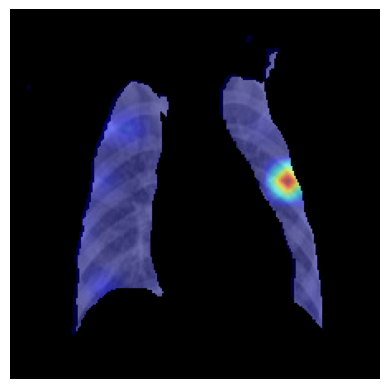

In [24]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

from torchvision.transforms import Lambda

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
    normalize,
])


# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained with DeiT
model = vit_LRP(num_classes=4).cuda()
# Load the state dict as it is
state_dict = torch.load('VIT_BASE.pth')

# Remove 'module.' prefix
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

# Load the adjusted state dict
model.load_state_dict(new_state_dict)
model.eval()
attribution_generator = LRP(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis
# Load and transform the image
image = Image.open('Bacterial_Pneumonia_segmented/person1666_bacteria_4416.jpg')
transformed_image = transform(image)
# Generate heatmap visualizatio
heatmap = generate_visualization(transformed_image)
mask_path = "Bacterial_Pneumonia_mask/Pred_person1666_bacteria_4416.jpg"
mask_image = Image.open(mask_path).convert('L')  # Ensure mask is in grayscale
mask_image = mask_image.resize((224, 224))  # Resize mask to match heatmap
mask = np.array(mask_image)
mask = mask.astype(np.float32) / 255  # Normalize mask
# Ensure mask is the correct shape (224,224,3)
mask = np.stack((mask,)*3, axis=-1)
# Apply the mask to the heatmap visualization
masked_heatmap = heatmap * mask  # This will broadcast correctly
# Display the masked heatmap
fig, axs = plt.subplots(1, 1)
axs.imshow(masked_heatmap.astype(np.uint8))  # Convert back to uint8 for display
axs.axis('off')
plt.show()

In [11]:
print(mask)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


RuntimeError: selected index k out of range

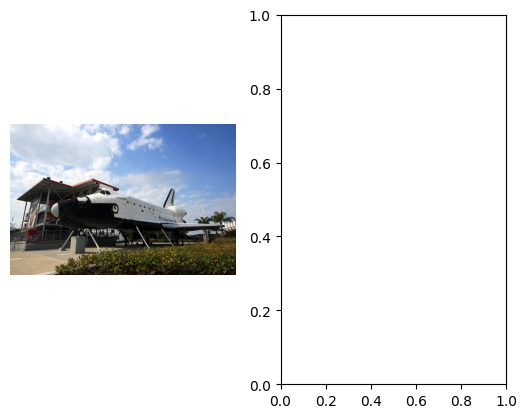

In [5]:
image = Image.open('image net/n04266014_space_shuttle.JPEG')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# dog 
# generate visualization for class 243: 'bull mastiff' - the predicted class
dog = generate_visualization(dog_cat_image)

# cat - generate visualization for class 282 : 'tiger cat'
# cat = generate_visualization(dog_cat_image, class_index=282)


axs[1].imshow(dog);
axs[1].axis('off');
# axs[2].imshow(cat);
# axs[2].axis('off');

Top 5 classes:
	0 : tench, Tinca tinca   		value = 7.209	 prob = 42.8%
	549 : envelope             		value = 5.033	 prob = 4.9%
	885 : velvet               		value = 3.688	 prob = 1.3%
	831 : studio couch, day bed		value = 3.660	 prob = 1.2%
	868 : tray                 		value = 3.501	 prob = 1.0%


NameError: name 'basset' is not defined

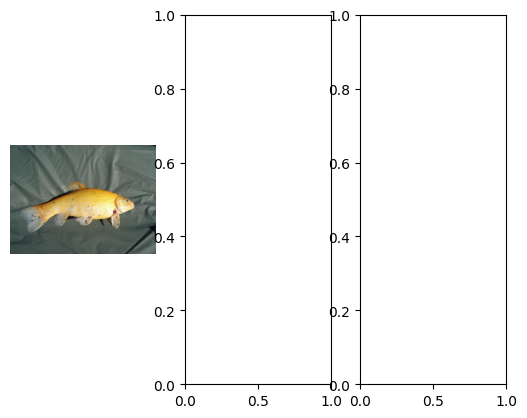

In [6]:
image = Image.open('image net/n01440764_tench.JPEG')
dog_bird_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_bird_image.unsqueeze(0).cuda())
print_top_classes(output)

# basset - the predicted class
# basset = generate_visualization(dog_bird_image, class_index=161)

# generate visualization for class 90: 'lorikeet'
parrot = generate_visualization(dog_bird_image)


axs[1].imshow(basset);
axs[1].axis('off');
axs[2].imshow(parrot);
axs[2].axis('off');

In [8]:
import os
from PIL import Image
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ... [Include all your pre-defined functions and model initialization here] ...

# Define the input and output directories
input_dir = 'imagenet-sample-images-master'
output_dir = 'heatmap output deit'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process each image in the input directory
for filename in os.listdir(input_dir):
    image_path = os.path.join(input_dir, filename)
    print("image_path:",image_path)
    
    original_image = Image.open(image_path)
    if original_image.mode != 'RGB':
        original_image = original_image.convert('RGB')
    processed_image = transform(original_image)

    # Generate predictions and heatmaps
    output = model(processed_image.unsqueeze(0).cuda())
    print_top_classes(output)  # Optional: Print top classes

    # Assuming you want to generate a heatmap for the top predicted class
    top_class_index = output.data.topk(1, dim=1)[1][0].item()
    heatmap = generate_visualization(processed_image, class_index=top_class_index)

    # Save the heatmap
    heatmap_filename = os.path.splitext(filename)[0] + '_heatmap.jpg'
    heatmap_path = os.path.join(output_dir, heatmap_filename)
    cv2.imwrite(heatmap_path, heatmap)
    print(f"Heatmap saved for {filename} as {heatmap_filename}")

print("Processing complete.")


image_path: imagenet-sample-images-master/n01440764_tench.JPEG
Top 5 classes:
	0 : tench, Tinca tinca   		value = 7.209	 prob = 42.8%
	549 : envelope             		value = 5.033	 prob = 4.9%
	885 : velvet               		value = 3.688	 prob = 1.3%
	831 : studio couch, day bed		value = 3.660	 prob = 1.2%
	868 : tray                 		value = 3.501	 prob = 1.0%
Heatmap saved for n01440764_tench.JPEG as n01440764_tench_heatmap.jpg
image_path: imagenet-sample-images-master/n01443537_goldfish.JPEG


Top 5 classes:
	1 : goldfish, Carassius auratus       		value = 6.547	 prob = 36.8%
	549 : envelope                          		value = 2.293	 prob = 0.5%
	21 : kite                              		value = 2.272	 prob = 0.5%
	111 : nematode, nematode worm, roundworm		value = 2.267	 prob = 0.5%
	769 : rule, ruler                       		value = 2.083	 prob = 0.4%
Heatmap saved for n01443537_goldfish.JPEG as n01443537_goldfish_heatmap.jpg
image_path: imagenet-sample-images-master/n01484850_great_white_shark.JPEG
Top 5 classes:
	2 : great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias		value = 7.043	 prob = 43.2%
	3 : tiger shark, Galeocerdo cuvieri                                                    		value = 4.099	 prob = 2.3%
	107 : jellyfish                                                                          		value = 3.698	 prob = 1.5%
	961 : dough                                                                              		value = 3.044	 prob = 0.8

Top 5 classes:
	340 : zebra                               		value = 6.759	 prob = 32.7%
	101 : tusker                              		value = 5.557	 prob = 9.8%
	386 : African elephant, Loxodonta africana		value = 5.477	 prob = 9.1%
	385 : Indian elephant, Elephas maximus    		value = 4.774	 prob = 4.5%
	925 : consomme                            		value = 2.237	 prob = 0.4%


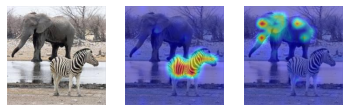

In [5]:
image = Image.open('samples/el2.png')
tusker_zebra_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(tusker_zebra_image.unsqueeze(0).cuda())
print_top_classes(output)

# zebra 
# zebra- the predicted class
zebra = generate_visualization(tusker_zebra_image, class_index=340)

# generate visualization for class 101: 'tusker'
tusker = generate_visualization(tusker_zebra_image, class_index=101)

axs[1].imshow(zebra);
axs[1].axis('off');
axs[2].imshow(tusker);
axs[2].axis('off');

Top 5 classes:
	207 : golden retriever  		value = 6.523	 prob = 35.7%
	208 : Labrador retriever		value = 4.288	 prob = 3.8%
	285 : Egyptian cat      		value = 3.641	 prob = 2.0%
	222 : kuvasz            		value = 3.422	 prob = 1.6%
	281 : tabby, tabby cat  		value = 2.778	 prob = 0.8%


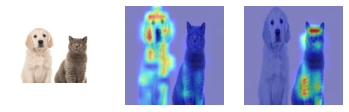

In [6]:
image = Image.open('samples/dogcat2.png')
dog_cat_image = transform(image)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.unsqueeze(0).cuda())
print_top_classes(output)

# golden retriever - the predicted class
dog = generate_visualization(dog_cat_image)

# generate visualization for class 285: 'Egyptian cat'
cat = generate_visualization(dog_cat_image, class_index=285)


axs[1].imshow(dog);
axs[1].axis('off');
axs[2].imshow(cat);
axs[2].axis('off');